# Wasserstein GAN (WGAN) by `Mr. Harshit Dawar!`
* Addresses the following problems of DCGANs
    * Mode Collapse
    * Vanishing Gradient
* It also requires less epochs to provide better results as compared to the DCGANs
* It takes more time to train as compared to DCGANs

In [1]:
# Importing the required libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers as ly
import tensorflow as tf
import os
import time
from IPython import display

## Downloading the Fashion MNIST Dataset, processing it, & visualizing it

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [3]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

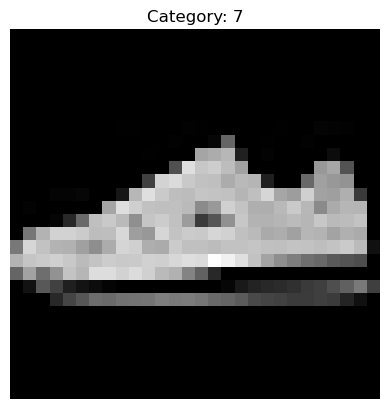

In [4]:
random_image = np.random.randint(0, X_train.shape[0])
plt.imshow(X_train[random_image], cmap = "gray")
plt.title("Category: " + str(y_train[random_image]))
plt.axis("off")
plt.show()

In [5]:
# Generating the 3rd Dimenstion for the image as per the requirement of the task
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

In [6]:
# Normalizing the images between -1 to 1
X_train = (X_train - 127.5) / 127.5

In [7]:
X_train.min(), X_train.max()

(-1.0, 1.0)

In [8]:
batch_size = 64
total_images = X_train.shape[0]
total_number_of_batches = total_images / batch_size

In [9]:
total_number_of_batches

937.5

In [10]:
X_train[0].dtype

dtype('float32')

In [11]:
# Changing the type of X_train from numpy array to tensorflow batchdataset
X_train = tf.data.Dataset.from_tensor_slices(X_train).shuffle(total_images).batch(batch_size)

In [12]:
type(X_train)

tensorflow.python.data.ops.dataset_ops.BatchDataset

## Creating the Generator for the WGAN
* It is same as DCGANs

In [13]:
def generator_builder():
    model = tf.keras.Sequential()
    
    # For the Random Noise/Image of a vector shape of 100 
    model.add(ly.Dense(units = 7 * 7 * 256, use_bias = False, input_shape = (100, )))
    model.add(ly.BatchNormalization())
    model.add(ly.LeakyReLU())
    
    # To Reshape the above flattened vector
    model.add(ly.Reshape((7, 7, 256)))
    
    # Conv2DTranspose Block 1 for generating a bigger image : Image size is 7x7x256
    model.add(ly.Conv2DTranspose(filters = 256, kernel_size = (3, 3), padding = "same", use_bias = False))
    model.add(ly.BatchNormalization())
    model.add(ly.LeakyReLU())
    
    # Conv2DTranspose Block 2 for generating a bigger image : Image size is 14x14x64
    model.add(ly.Conv2DTranspose(filters = 64, kernel_size = (3, 3), padding = "same", strides = (2, 2), use_bias = False))
    model.add(ly.BatchNormalization())
    model.add(ly.LeakyReLU())
    
    # Conv2DTranspose Block 3 for generating a bigger image : Image size is 28x28x1
    model.add(ly.Conv2DTranspose(filters = 1, kernel_size = (3, 3), padding = "same", strides = (2, 2), use_bias = True, activation = "tanh"))
    
    model.summary()
    return model

In [14]:
# Defining a generator
generator = generator_builder()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 256)        589824    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 256)        1

In [15]:
random_noise = tf.random.normal([1, 100])
random_noise

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[ 1.0118744 , -0.04351402,  1.7089958 ,  1.0528617 ,  0.33298644,
        -0.37482157,  0.00300638, -0.65885407, -0.89043593,  0.3171842 ,
        -0.14011735,  0.38389325, -1.1781405 ,  0.32206866,  0.6608265 ,
         0.73724914, -0.2241671 ,  0.04430045,  1.7256496 , -0.56036836,
        -0.5970544 ,  2.338875  , -0.23668285, -0.5712346 ,  1.341983  ,
         0.44172984, -0.22931303, -0.65600073,  0.7876422 , -1.1878595 ,
         0.12950191,  0.57971984, -0.47907382,  0.7042478 ,  0.09750587,
         0.59240174,  1.571543  , -1.6999662 , -0.5584544 ,  1.049063  ,
         0.7164317 , -0.3739789 ,  1.6104847 ,  0.5225296 ,  0.20770551,
         0.23591818, -0.04172134, -1.523563  , -0.48423406, -0.06442713,
         0.46693876, -0.78699446, -1.0927438 , -0.78400636, -1.4206134 ,
        -1.6887615 ,  1.0633197 , -0.52885467,  0.4678543 ,  0.6733271 ,
         1.5773205 ,  1.8496404 ,  1.0434806 ,  1.5458506 ,  1.4073762 ,
 

In [16]:
random_image_generated_from_generator = generator(random_noise, training = False)

In [17]:
random_image_generated_from_generator.shape

TensorShape([1, 28, 28, 1])

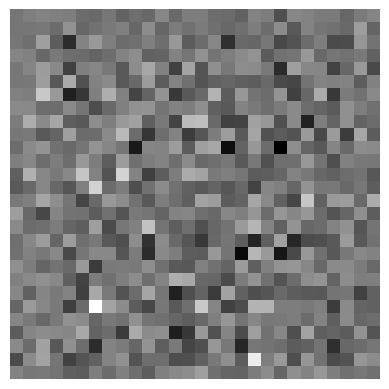

In [18]:
plt.imshow(random_image_generated_from_generator[0], cmap = "gray")
plt.axis("off")
plt.show()

## Creating the Discriminator (Critic) for the WGANs

In [19]:
def discriminator_builder():
    model = tf.keras.Sequential()
    
    # Image Shape: 14x14x64
    model.add(ly.Conv2D(filters = 64, kernel_size = (3, 3), input_shape = [28, 28, 1], strides = (2, 2), padding = "same"))
    model.add(ly.LeakyReLU())
    model.add(ly.Dropout(0.3))
    
    # Image Shape: 7x7x128
    model.add(ly.Conv2D(filters = 128, kernel_size = (3, 3), strides = (2, 2), padding = "same"))
    model.add(ly.LeakyReLU())
    model.add(ly.Dropout(0.3))
    
    # Flattening the network
    model.add(ly.Flatten())
    model.add(ly.Dense(units = 1))  # To get the logits only
    
    model.summary()
    return model

In [20]:
discriminator = discriminator_builder()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [21]:
discriminator.input

<KerasTensor: shape=(None, 28, 28, 1) dtype=float32 (created by layer 'conv2d_input')>

In [22]:
discriminator(random_image_generated_from_generator, training = False)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[8.0159545e-05]], dtype=float32)>

In [23]:
# Around 50% is the answer, that means its a guess, & this is the expected behaviour since the model is not trained.
tf.sigmoid(-0.00049801)

<tf.Tensor: shape=(), dtype=float32, numpy=0.4998755>

## Generating the Wasserstein Loss Function
* Wasserstein Loss is equal to the difference between the expected value (mean) of the discriminiator for the authentic images & the expected value (mean) of the discriminiator for the fake images (output of generator)
* The objective of the discriminator is to maximize the difference, whereas the objective of the generator is to minimize the difference.

In [24]:
# According to the original Research Paper, the equation for the generator loss is implemented here
def wloss_generator(fake_output):
    return -1 * tf.math.reduce_mean(fake_output)

In [25]:
# According to the original Research Paper, the equation for the discriminator/critic loss is implemented here
def wloss_discriminator(real_output, fake_output, gradient_penalty):
    critic_lambda = 10
    return tf.math.reduce_mean(fake_output) - tf.math.reduce_mean(real_output) + critic_lambda * gradient_penalty

## Generating the Gradient Penalty (GP) Function!
* **To use Wasserstein Loss, the function should be 1 - L (Lipschitz) continuous, & to make it so, we need to use Gradient Penalty.**
* This variation is known as **WGAN-GP**

#### Steps to calculate Gradient Penalty are as follows:
* Generate an interpolated image from the real & fake image as follows: **(real_image * epsilon) + (fake_image * (1 - epsilon))**
* Calculate the gradient of the discriminator/critic output relative to the interpolated image.
* Calculate the gradient norm.
* Calculate penalty as the average/mean of the square of (norm - 1), since norm is expected to be close to 1.

In [26]:
def gradient_penalty_calculator(real_image, fake_image, epsilon):
    # Step 1:
    interpolated_image = real_image * epsilon + (fake_image * (1 - epsilon))
    
    # Step 2:
    with tf.GradientTape() as tape:
        tape.watch(interpolated_image)
        output = discriminator(interpolated_image)[0]               # To get the logits from the dense layer of the discriminator/critic
    gradient = tape.gradient(output, interpolated_image)[0]
    
    # Step 3:
    gradient_norm = tf.norm(gradient)
    
    # Step 4:
    gradient_penalty = tf.math.reduce_mean((gradient_norm - 1) ** 2)
    
    return gradient_penalty

In [27]:
generator_optimizer = tf.keras.optimizers.Adam(beta_1 = 0.3, beta_2 = 0.7)
discriminator_optimizer = tf.keras.optimizers.Adam(beta_1 = 0.3, beta_2 = 0.7)

### Creating the checkpoints for the model to be saved & retrained as & when required (specially for big training)

In [28]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'checkpoints')
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)

## Training WGANs Model

In [29]:
def training_step(images):
    random_noise = tf.random.normal([batch_size, 100])
    
    # As in WGAN, we need to train the discriminator more times as compared to generator
    extra_steps_of_discriminator_training = 3
    
    for i in range(extra_steps_of_discriminator_training):
        with tf.GradientTape() as dis_tape:
            generated_images = generator(random_noise, training = True)
            real_output = discriminator(images, training = True)
            fake_output = discriminator(generated_images, training = True)
            epsilon = tf.random.normal([batch_size, 1, 1, 1], mean = 0.0, stddev = 1.0)
            gp = gradient_penalty_calculator(real_image = images, fake_image = generated_images, epsilon = epsilon)
            
            dis_loss = wloss_discriminator(real_output = real_output, fake_output = fake_output, gradient_penalty = gp)
            discriminator_gradients = dis_tape.gradient(dis_loss, discriminator.trainable_variables)
            discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))
            
    with tf.GradientTape() as gen_tape:
        generated_images = generator(random_noise, training = True)
        fake_output = discriminator(generated_images, training = True)
        gen_loss = wloss_generator(fake_output = fake_output)
    generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))

In [30]:
def generate_and_save_the_image(model, epoch, image):
    prediction = model(image, training = False)
    plt.figure(figsize = (5, 5))
    for i in range(prediction.shape[0]):
        plt.subplot(5, 5, i + 1)
        plt.imshow(prediction[i, :, :, 0] * 127.5 + 127.5, cmap = "gray")
        plt.axis("off")
    plt.savefig("img_epoch_{:04d}".format(epoch))
    plt.show()

In [31]:
image_for_testing = tf.random.normal([25, 100])

In [32]:
def train(data, epochs):
    for epoch in range(epochs):
        start_time = time.time()
        for image_batch in data:
            if len(image_batch) == batch_size:
                training_step(image_batch)
        generate_and_save_the_image(generator, epoch = epoch + 1, image = image_for_testing)
        if (epoch + 10) % 10 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
        print("Time taken to process {} epoch is {} seconds".format(epoch + 1, time.time() - start_time))
    generate_and_save_the_image(generator, epochs, image_for_testing)
    generator.save("generator.h5")

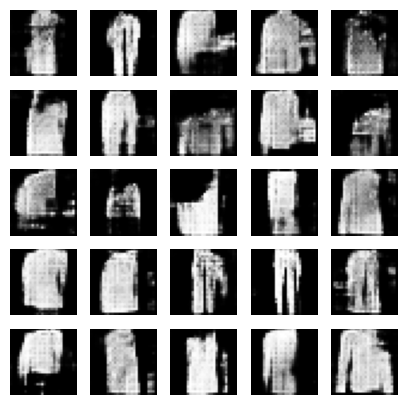

Time taken to process 1 epoch is 549.9364113807678 seconds


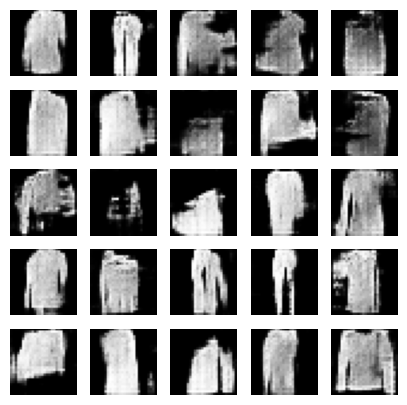

Time taken to process 2 epoch is 550.9227092266083 seconds


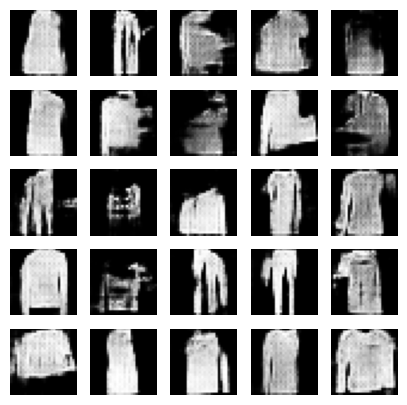

Time taken to process 3 epoch is 549.8795318603516 seconds


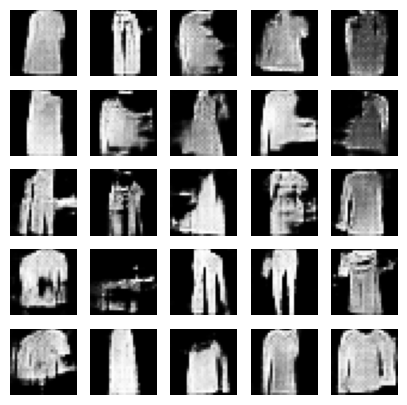

Time taken to process 4 epoch is 568.2455806732178 seconds


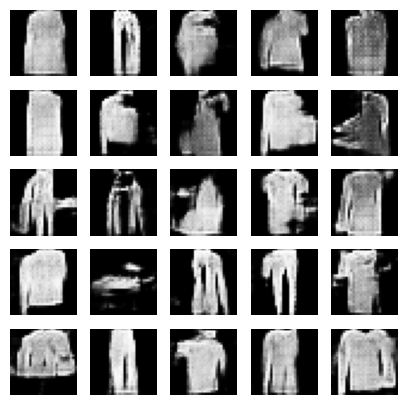

Time taken to process 5 epoch is 554.1798226833344 seconds


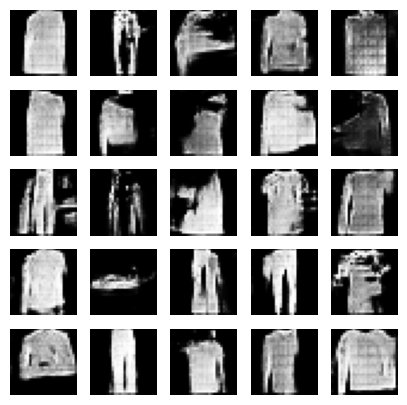

Time taken to process 6 epoch is 552.2703940868378 seconds


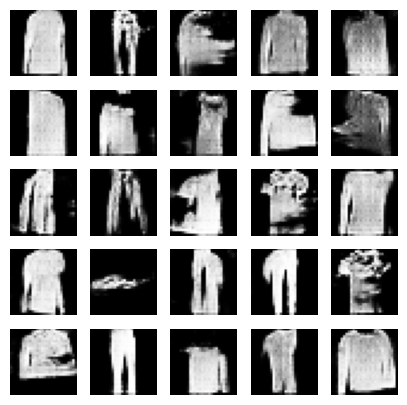

Time taken to process 7 epoch is 555.7148621082306 seconds


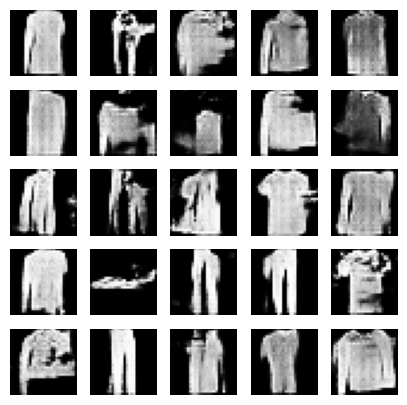

Time taken to process 8 epoch is 559.3033454418182 seconds


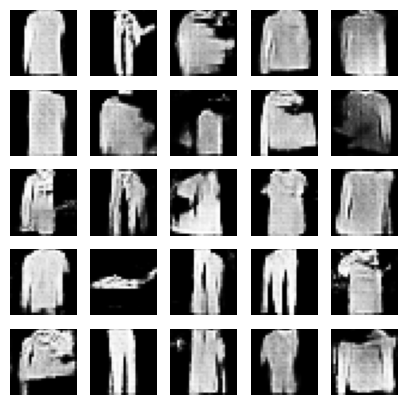

Time taken to process 9 epoch is 569.3611681461334 seconds


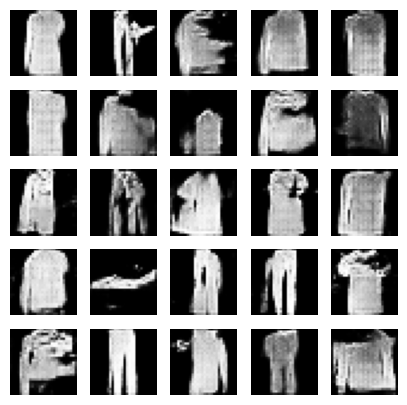

Time taken to process 10 epoch is 545.7928006649017 seconds


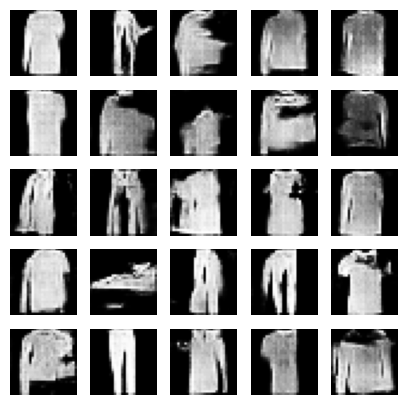

Time taken to process 11 epoch is 1044.7937326431274 seconds


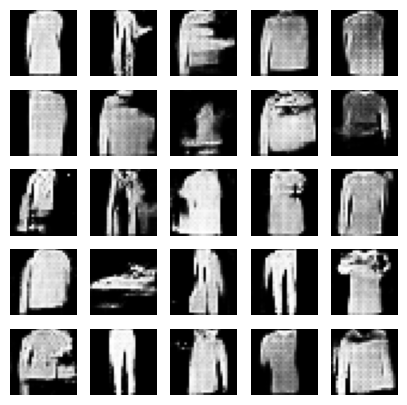

Time taken to process 12 epoch is 1050.9600143432617 seconds


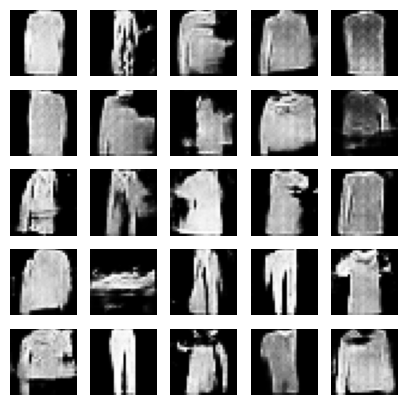

Time taken to process 13 epoch is 1031.3541858196259 seconds


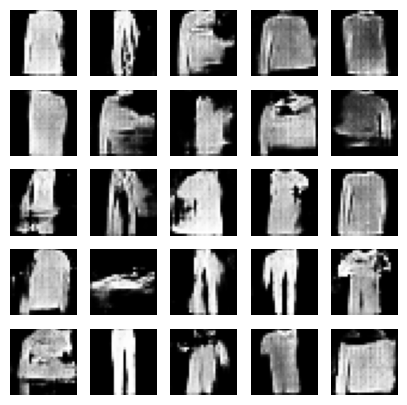

Time taken to process 14 epoch is 1018.872225522995 seconds


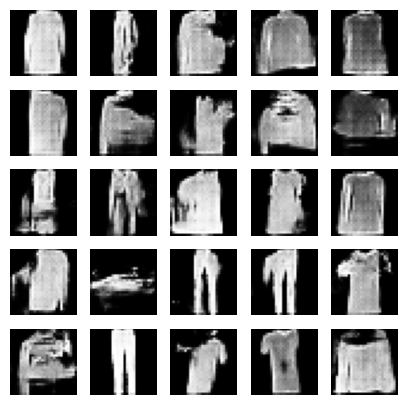

Time taken to process 15 epoch is 1053.199558019638 seconds


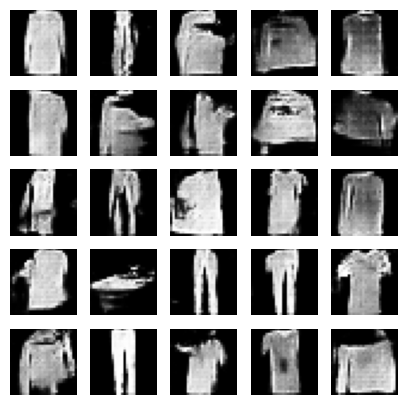

Time taken to process 16 epoch is 939.8626039028168 seconds


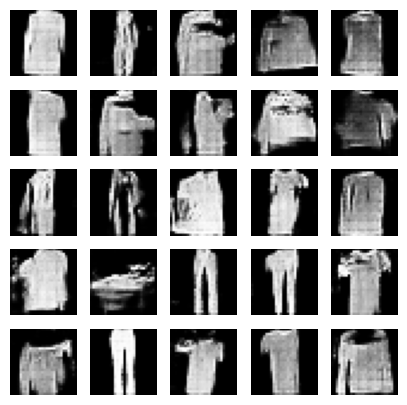

Time taken to process 17 epoch is 550.4192547798157 seconds


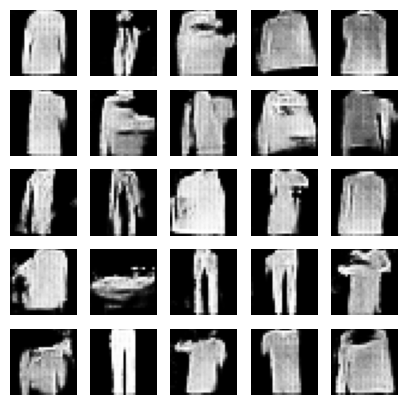

Time taken to process 18 epoch is 545.1586780548096 seconds


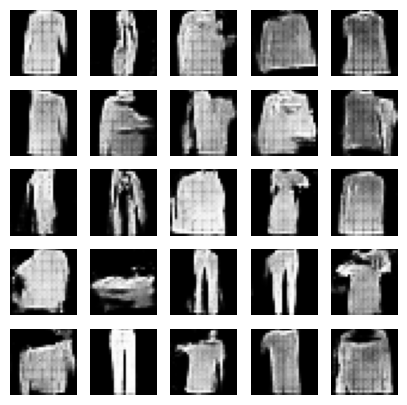

Time taken to process 19 epoch is 546.3564124107361 seconds


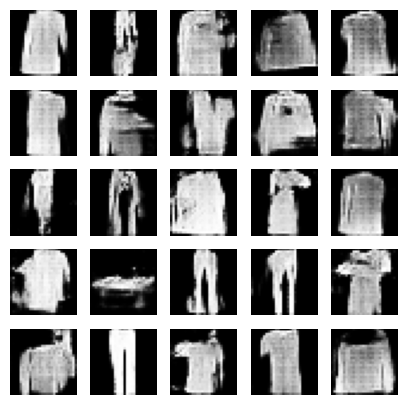

Time taken to process 20 epoch is 565.3487160205841 seconds


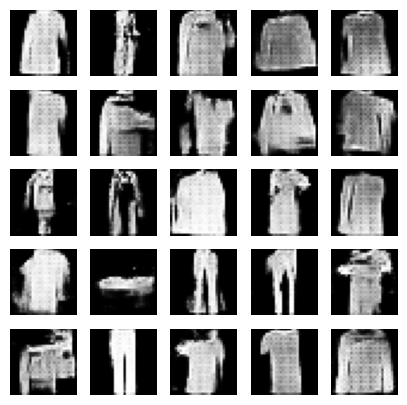

Time taken to process 21 epoch is 577.7687191963196 seconds


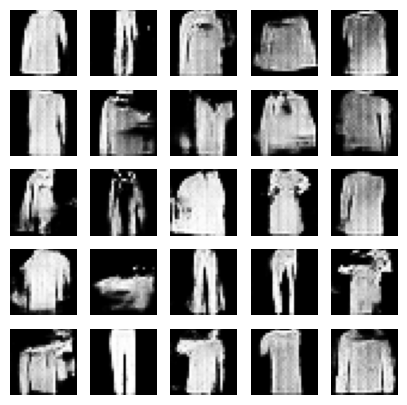

Time taken to process 22 epoch is 577.2127921581268 seconds


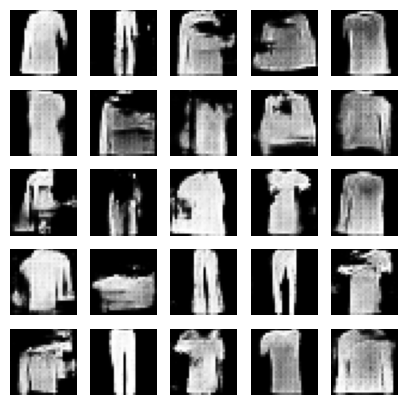

Time taken to process 23 epoch is 577.0450632572174 seconds


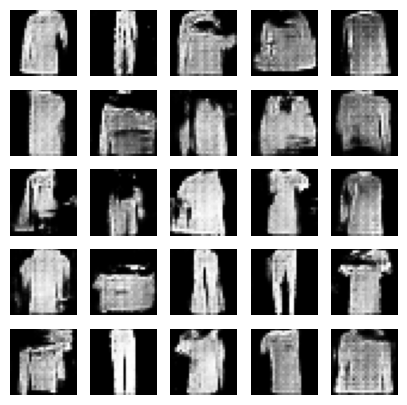

Time taken to process 24 epoch is 575.1468043327332 seconds


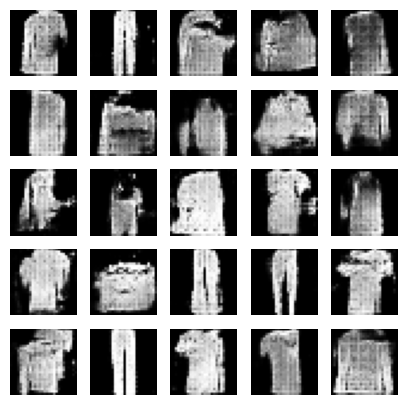

Time taken to process 25 epoch is 575.2472286224365 seconds


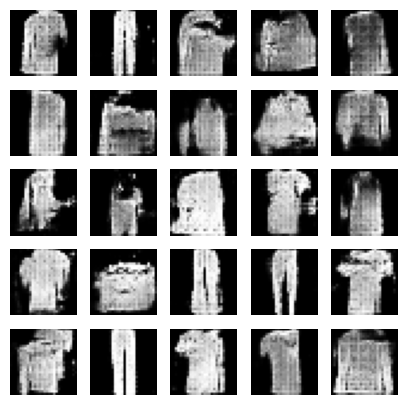

In [33]:
train(X_train, epochs = 25)